# Get Cocrystalized molecules from PDB

- Extract the cocrystalized molecules from the PDB structures.
- The active site is defined by a reference PDB structure and the name of the cocrystalized molecule (3-letter identifier code).

In [1]:
import itertools
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
# Read the metadata dataframe created in the previous notebook
prot_name = 'cdk2'
df_prot = pd.read_pickle(f'./df_metadata_{prot_name}_pdbids.pkl')

In [3]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} of {len(df_prot)} structures have at least one HETATM molecule.')

394 of 425 structures have at least one HETATM molecule.


In [4]:
# How many cocrystalized molecules are there?
# A set of all HETATM molecules
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(f'There are a total of {len(lig_full_list)}', 
       'HETATM molecules (duplicates included).')

lig_all_list = list(set(lig_full_list))
print(f'There are {len(lig_all_list)} unique', 
       'HETATM molecules (without duplicates).')

There are a total of 541 HETATM molecules (duplicates included).
There are 359 unique HETATM molecules (without duplicates).


## Visualize pocket residues

In [5]:
from helper_modules.get_cocristalized_ligands \
     import get_pocket_ligand, PocketResidues

In [6]:
# Use a reference structure to visualize the pocket residues
ref_struc_id    = '1fin'
ref_ligand_name = 'ATP'

In [7]:
pkt_info = PocketResidues(ref_struc_id, ref_ligand_name)
pocket_residues_str = pkt_info.get_pocket_residues_as_list(cutoff = 8)
print('Indices of pocket redsidues:', pocket_residues_str)

Indices of pocket redsidues: 9 10 11 12 13 14 15 16 17 18 19 20 30 31 32 33 47 51 64 65 79 80 81 82 83 84 85 86 87 88 89 127 129 130 131 132 133 134 135 142 143 144 145 146 147 148


In [8]:
view = pkt_info.visualize_pocket()
view

NGLWidget()

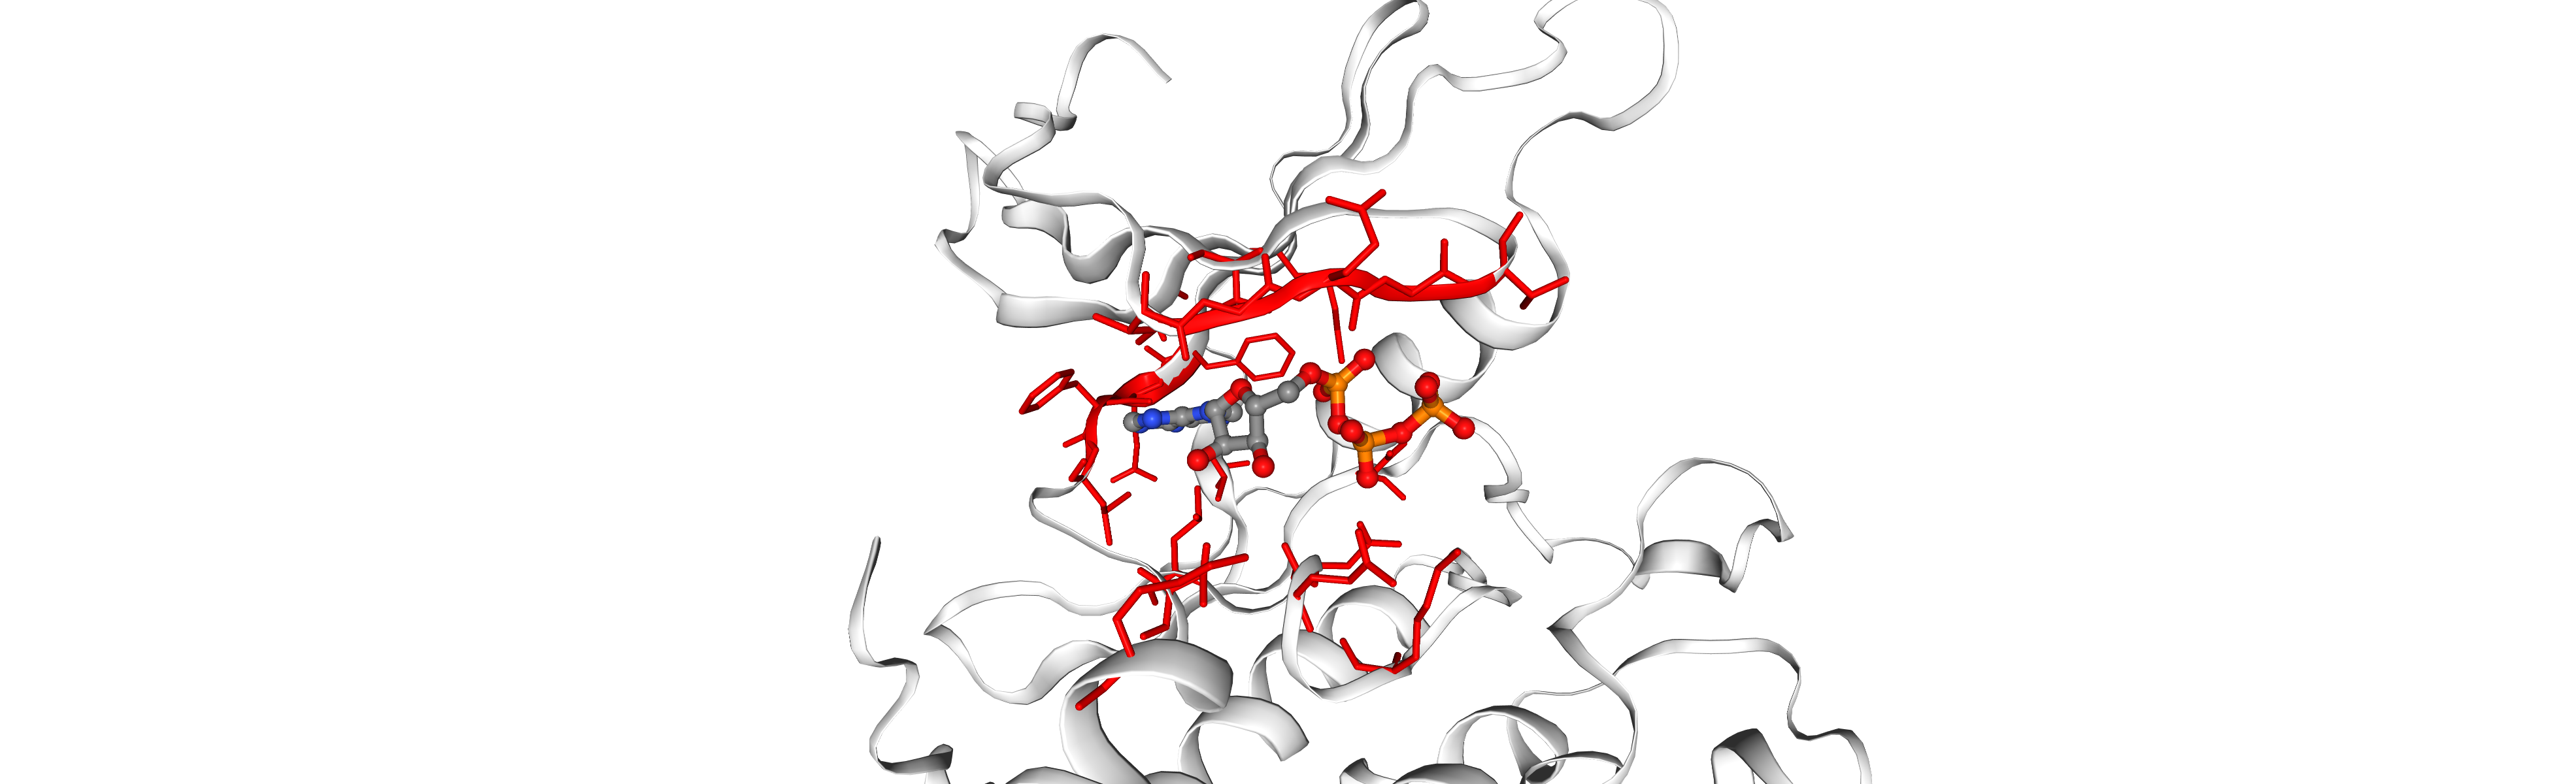

In [10]:
view.render_image()
view._display_image()

## Perform the analysis
### Identify and save the molecules bound to the active site

- Define the input files and the output directory.

In [10]:
# Define the output directories
OUT_MAIN           = '../../data/crystal_confs/'
IN_DIR_PROT_CHAINS = f'{OUT_MAIN}/pdb_chains'
IN_DIR_RAW_LIGS    = f'{OUT_MAIN}/raw_ligands'
OUT_DIR_PREP_LIGS  = f'{OUT_MAIN}/pocket_ligands'

# Create the output directory if it doesnt exists
Path(OUT_DIR_PREP_LIGS).mkdir(parents = True, exist_ok = True)

Update the **metadata DataFrame** with the information of the ligands:
- `LigPktName`: Name of the molecule found inside the pocket.
- `LigMW`: Molecular weight of the molecule (no Hydrogens).
- `LigNHeavyAtoms`: Number of heavy atoms of the molecule.

**Criteria** to identify a molecule as a <mark>ligand bound to the protein pocket</mark> (active site):
- The molecule has a `HETATM` identifier.
- The geometric center of the molecule is at most 10 Angstroms from the geometric center of the pocket. 
    - As an example, for `3pxf` the ligand `2AN` is 9.05 Angstroms from the pocket.
- The molecule has at least 12 heavy atoms (`min_heavy_atoms`). 
    - The molecule is not a solvent molecule.
- If two or more molecules satisfy the above criteria:
    - Select the molecule closest to the protein's pocket geometric center.
    
Additionally, only the coordinates of the molecule identified as ligand will be saved in the `OUT_DIR_PREP_LIGS` directory.

In [ ]:
# Get all pocket ligands
lig_names, lig_mws, lig_n_atoms, lig_distances = [], [], [], []

for pdb_id in df_prot['PDB_ID']:
    name, mw, num_heavy_atoms, dist = get_pocket_ligand(
                        pdb_id          = pdb_id, 
                        pocket_residues = pocket_residues_str,
                        raw_lig_dir     = IN_DIR_RAW_LIGS,
                        prot_chain_dir  = IN_DIR_PROT_CHAINS,
                        pk_ligs_dir     = OUT_DIR_PREP_LIGS,
                        write_files     = True, 
                        min_heavy_atoms = 12,
                        min_dist_from_pkt = 10
                 )
    lig_names.append(name) 
    lig_mws.append(mw)
    lig_n_atoms.append(num_heavy_atoms)
    lig_distances.append(dist)
    
df_prot_lig = df_prot.copy(deep = True)
df_prot_lig["LigPktName"]      = lig_names
df_prot_lig["LigMW"]           = lig_mws
df_prot_lig["LigNHeavyAtoms"]  = lig_n_atoms
df_prot_lig["LigDistToPocket"] = lig_distances

Protein 1aq1
	Molecules found: ['STU']
Protein 1b38
	Molecules found: ['ATP', 'MG']
Protein 1b39
	Molecules found: ['ATP', 'MG']
Protein 1buh
	The protein 1buh has no ligand inside the pocket.
Protein 1ckp
	Molecules found: ['EDO', 'PVB']
Protein 1di8
	Molecules found: ['DTQ']
Protein 1dm2
	Molecules found: ['EDO', 'HMD']
Protein 1e1v
	Molecules found: ['CMG']
Protein 1e1x
	Molecules found: ['NW1']
Protein 1e9h
	Molecules found: ['INR', 'TPO']
Protein 1f5q
	The protein 1f5q has no ligand inside the pocket.
Protein 1fin
	Molecules found: ['ATP']
Protein 1fq1
	Molecules found: ['ATP', 'MG']
Protein 1fvt
	Molecules found: ['106']
Protein 1fvv
	Molecules found: ['107']
Protein 1g5s
	Molecules found: ['I17']
Protein 1gih
	Molecules found: ['1PU']
Protein 1gii
	Molecules found: ['1PU']
Protein 1gij
	Molecules found: ['2PU']
Protein 1gy3
	Molecules found: ['ATP', 'MG', 'NO3', 'TPO']
Protein 1gz8
	Molecules found: ['MBP']
Protein 1h00
	Molecules found: ['FAP']
Protein 1h01
	Molecules found: ['

Protein 2x1n
	Molecules found: ['X1N']
Protein 2xmy
	Molecules found: ['CDK']
Protein 2xnb
	Molecules found: ['Y8L']
Protein 3bht
	Molecules found: ['MFR', 'TPO']
Protein 3bhu
	Molecules found: ['MHR', 'TPO']
Protein 3bhv
	Molecules found: ['TPO', 'VAR']
Protein 3ddp
	Molecules found: ['RC8', 'TPO']
Protein 3ddq
	Molecules found: ['RRC', 'TPO']
Protein 3dog
	Molecules found: ['NNN', 'TPO']
Protein 3eid
	Molecules found: ['PO5']
Protein 3ej1
	Molecules found: ['5BP']
Protein 3eoc
	Molecules found: ['T2A']
Protein 3ezr
	Molecules found: ['EZR']
Protein 3ezv
	Molecules found: ['EZV']
Protein 3f5x
	Molecules found: ['EZV', 'GOL']
Protein 3fz1
	Molecules found: ['B98']
Protein 3ig7
	Molecules found: ['EFP']
Protein 3igg
	Molecules found: ['EFQ']
Protein 3le6
	Molecules found: ['2BZ']
Protein 3lfn
	Molecules found: ['A27']
Protein 3lfq
	Molecules found: ['A28']
Protein 3lfs
	Molecules found: ['A07']
Protein 3my5
	Molecules found: ['RFZ', 'TPO']
Protein 3ns9
	Molecules found: ['NS9']
Protein 

## Save the updated DataFrame

In [15]:
file = f'./df_metadata_{prot_name}_pdbids_LIGS.pkl'
df_prot_lig = pd.read_pickle(file)
df_prot_lig.sample(10)

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,NonStndResnames,NonStndResnums,LigPktName,LigMW,LigNHeavyAtoms,LigDistToPocket
180,2xnb,discovery and characterisation of 2-anilino-4-...,2010-11-10,1,A,1.85,0.993,99.329,1,[2],"[[39, 40]]",1,[Y8L],None,None,Y8L,360.307900,27.0,4.078969
369,5jq5,inhibitor selectivity for cyclin-dependent kin...,2017-02-08,1,A,1.94,0.993,96.309,2,"[2, 9]","[[1, 2], [37, 45]]",2,"[I74, ACT]",None,None,I74,364.275000,29.0,3.540072
96,2btr,structure-based drug design to the discovery o...,2005-11-09,1,A,1.85,0.993,92.282,2,"[11, 12]","[[36, 46], [150, 161]]",1,[U73],None,None,U73,246.223600,18.0,4.932182
172,2wih,"identification of n,1,4,4-tetramethyl-8-{[4-(4...",2009-07-28,"1,2",A,2.5,0.993,100.0,0,[],[],1,[P48],None,None,P48,428.320500,34.0,3.184733
415,6yl6,multiparameter kinetic analysis for covalent f...,2020-07-22,1,A,1.7,0.993,100.0,0,[],[],0,[],None,None,None,NaN,NaN,NaN
258,3r9d,development of highly potent and selective dia...,2012-10-31,1,A,1.95,0.993,98.658,1,[4],"[[37, 40]]",1,[X6B],None,None,X6B,393.331303,27.0,3.149971
380,5osm,high-throughput kinetic analysis for target-di...,2018-03-14,1,A,1.77,0.993,96.644,2,"[8, 2]","[[37, 44], [296, 297]]",1,[AEQ],None,None,AEQ,230.154700,18.0,2.299807
404,6q4d,"fraglites-minimal, halogenated fragments displ...",2019-03-20,1,A,1.07,0.993,96.644,3,"[7, 1, 2]","[[38, 44], [177, 177], [296, 297]]",1,[HHT],None,None,HHT,235.998500,13.0,3.701208
285,3sqq,development of highly potent and selective dia...,2012-10-31,1,A,1.85,0.993,96.644,2,"[4, 6]","[[37, 40], [151, 156]]",2,"[99Z, EDO]",None,None,99Z,372.336900,26.0,3.679913
110,2c6o,"triazolo[1,5-a]pyrimidines as novel cdk2 inhib...",2005-12-07,1,A,2.1,0.993,97.315,2,"[6, 2]","[[38, 43], [296, 297]]",1,[4SP],None,None,4SP,380.296000,28.0,3.948652
